# Algoritmo de Gillespie para la expresión genética de un gen constitutivo en una $\textit{E. coli}$ ideal

Considérese una $\textit{E. coli}$ ideal que crece, pero no se divide y que únicamente tiene un gen constitutivo. Las ecuaciones diferenciales estocásticas que describen la expresión genética de ese gen constitutivo, siguiendo lo postulado por el dogma central de la biología molecular, serán

\begin{equation}
\dot{r} = k_r - \gamma_r r
\end{equation}

\begin{equation}
\dot{p} = k_p r - \gamma_p p
\end{equation}

donde $k_r$ es la tasa con la que se transcribe el ADN en r, donde r la cantidad en número de moléculas de ARNm, $\gamma_r$ es la tasa con la que se degrada el ARNm, $k_p$ es la tasa con la que se traduce r en p, donde p es la cantidad en número de moléculas de proteína, y $\gamma_p$ es la tasa de degradación de proteína, que en este caso corresponde a la degradación por dilución.

Inicializamos las constantes definidas anteriormente de acuerdo con los valores estimados para la $\textit{E. coli}$

In [1]:
γr, kr, γp, kp = 1/5,1,1/45,50

Importamos los paquetes que serán necesarios para correr el algoritmo

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

from numba import jit,njit,float64,int32
import numba as nb

Definimos la función de Gillespie, que efectuará el algoritmo de Gillespie para la simulación de la dinámica estocástica de las especies químicas r y p, ARNm y proteína, respectivamente, para la expresión del gen constitutivo. 

In [4]:
@njit('f8[:](f8[:],f8)')
def Gillespie(trp0,tmax):
    
    '''
    Gillespie(trp0, tmax)

    Return a ndarray from the given initial state with the last times, number of mRNA and the last number of proteins.
    
    Parameters
    ----------
    trp0 : array like
        Array like with the initial state of a every single cell. It must be in this order: time,
        number of mRNA, number of proteins.
    tmax : int
        Maximum time to be run in the simulation
    
    Returns
    -------
    out : ndarray
        Array of the last time, number of mRNA and the last number of proteins obtained after the stochastic 
        simulation of a single system.    
    
    '''
    
    t,r,p =trp0 

    while t < tmax:
        s1 = kr
        s2 = γr*r
        s3 = kp*r
        s4 = γp*p
        st = s1+s2+s3+s4
        τ = (-1/st)*np.log(np.random.rand())
        x = np.random.rand()
        if(x< s1/st):
            r+=1
        elif(x<(s1+s2)/st):
            r-=1
        elif(x<(s1+s2+s3)/st):
            p+=1
        else:
            p-=1
        t+=τ
    return np.array([t,r,p]) 

t es el tiempo, r el número de ARNm, p el número de proteínas. Inicialmente estas 3 variables inician en los valores dados por el vector trp0. 

Luego, mientras el tiempo t sea menor o igual que el tiempo tmax dado por parámetro, que es el tiempo máximo en el que se simulará, definimos los eventos $s_1$,$s_2$,$s_3$,$s_4$, donde $s_1$ es el evento de creación de ARNm con tasa de creación $k_r$, $s_2$ es el evento de degradación de ARNm con tasa $\gamma_r$, $s_3$ es el evento de creación de proteínas con tasa $k_p$, $s_4$ es el evento de degradación de proteína con tasa $\gamma_p$. La cantidad $s_t$ corresponde a la suma de los cuatro eventos mencionados antes, que salen de las ecuaciones diferenciales estocásticas expuestas al principio.

La cantidad $\tau$ es un tiempo aleatorio con distribución exponencial, inversamente proporcional a $s_t$, que es el tiempo en el que ocurre un evento. La cantidad x es un número aleatorio, distinto de $\tau$, con distribución uniforme. Si x es menor que la $s_1/s_t$, ocurre el evento de creación de ARNm y se añade una molécula de ARNm. Si x es menor que $\left(s_1+s_2\right)/s_t$, ocurre el evento de degradación de ARNm y se resta una molécula de ARNm.Si $\left(s_1+s_2+s_3\right)/s_t$, ocurre elevento de creación de proteína y se añade una molécula de proteína. Si x no cumple con ninguna de las tres condiciones anteriores, se resta una proteína. El tiempo avanza de acuerdo a $\tau$, por lo que al tiempo inicial se le suma el tiempo $\tau$. Luego, el algoritmo retorna un array de numpy con el tiempo final, el ARNm final y la proteína final. 

Definimos la función Estado_celula, que será la encargada de evolucionar la célula de interés en el tiempo de acuerdo con las condiciones iniciales dadas y un vector de tiempos que contendrá los tiempos de muestreo del algoritmo.

In [5]:
@njit('f8[:,:](f8[:],f8[:])')
def Estado_celula(X0,tiempos):
    '''
    Estado_celula(X0,tiempos)

    Returns a matrix with the evolved genetic expression of a single cell.
    
    Parameters
    ----------
    X0 :ndarray 
        Vector with the system's initial state.
        It has as many rows as elements have tiempos and as many columns as evaluated chemical species.
    tiempos : numpy linspace, ndarray, array like
        Vector containing the sampling times to evolve the system.
    
    Returns
    -------
    out : matrix, 2D ndarray
        2D ndarray with the evolved system data.
    
    Example
    --------
    >>> x0 = np.array([0.0,0.0,0.0])             #time starts in 0.0, number of mRNA starts in 0.0 
                                                 #and number of proteins starts in 0.0, respectively.
                                               
    >>> Estado_celula(x0,np.linspace(0,200,10))  #Evolves a single cell with initial conditions x0 and a
                                                 #equispaced sampling time vector with 10 elements from 
                                                 #0 to 200. We chose only 10 elements for simplicity, but
                                                 #there are 50 by default. 
                                               
    array([[0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
    [2.22233941e+01, 6.00000000e+00, 4.58400000e+03],
    [4.44470482e+01, 3.00000000e+00, 7.73200000e+03],
    [6.66697353e+01, 5.00000000e+00, 5.90500000e+03],
    [8.88922698e+01, 4.00000000e+00, 5.80100000e+03],
    [1.11113080e+02, 6.00000000e+00, 7.65800000e+03],
    [1.33335290e+02, 7.00000000e+00, 6.79300000e+03],
    [1.55556091e+02, 7.00000000e+00, 1.00870000e+04],
    [1.77778084e+02, 2.00000000e+00, 9.95200000e+03],
    [2.00003693e+02, 3.00000000e+00, 8.36100000e+03]])
    
    Note that the first row is the initial condition vector x0.

    '''
    
    X = np.zeros((len(tiempos),len(X0)))
    X[0] = X0
    
    for i in range(1,len(tiempos)):
        X[i] = Gillespie(X[i-1],tiempos[i])
    
    return X

Sea $\vec{x}_0 = \left[t_0 = 0.0, r_0 = 0.0, p_0 = 0.0\right]$, el vector de condiciones iniciales para el tiempo, cantidad de ARNm en número de moléculas y cantidad de proteínas en número de moléculas. Sea X, la matriz, definida como

$$X = \begin{bmatrix}t_0 & r_0 & p_0\\t_1 & r_1 & p_1 \\ t_2 & r_2 & p_2 \\ t_3 & r_3 & p_3 \\ . & . & . \\ . & . & . \\ . & . & .\\ t_i & r_i & p_i \\ . & . & . \\ . & . & . \\ . & . & .\\t_{n} & r_{n} & p_{n} \end{bmatrix}$$

donde $t_{n}$, $r_{n}$, $p_{n}$ son el tiempo máximo, la cantidad de ARNm en número de moléculas en el tiempo máximo y la cantidad de proteína en número de moléculas en el tiempo máximo. El tiempo máximo se define como el último elemento del vector tiempos, que es el vector que contiene los tiempos de muestreo. La cantidad n es el número de elementos que tiene el vector tiempo máximo.

Es importante destacar que X tendrá tantas filas como elementos tenga el vector tiempos y tantas columnas como especies químicas se estén evaluando, de manera que, en general, si se tienen 

$$X = \begin{bmatrix}t_0 & e_{0,1} & e_{0,2} & e_{0,3} & . & . &. & e_{0,j} & . & . &. & e_{0,m} \\t_1 & e_{1,1} & e_{1,2} & e_{1,3} & . & . & . & e_{1,j} & . & . & . & e_{1,m} \\ t_2 & e_{2,1} & e_{2,1} & e_{2,3} & . & . & . & e_{2,j}& . & . & . & e_{2,m} \\ t_3 & e_{3,1} & e_{3,2} & e_{3,3} & . & . & . & e_{3,j}& . & . & . & e_{3,m}\\ . & . & . & . & . & . & . & . & . & . & . & .\\ . & . & . & . & . & . & . & . & . & . & . & .\\  . & . & . & . & . & . & . & . & . & . & . & .\\ t_i & e_{i,1} & e_{i,2} & e_{i,3} & . & . & . & e_{i,j} & . & . & . &e_{i,m}\\ . & . & . & . & . & . & . & . & . & . & . & .\\  . & . & . & . & . & . & . & . & . & . & . & .\\  . & . & . & . & . & . & . & . & . & . & . & .\\ t_{n} & e_{n,1} & e_{n,2} & e_{n,3} & . & . & . & e_{n,j} & . & . & . & e_{n,m} \end{bmatrix}$$

donde $e_{i,j}$ es la j-ésima especie química en la i-ésimo tiempo, donde el i-ésimo tiempo es el i-ésimo elemento del vector tiempos. La cantidad n es el número de elementos del vector tiempos y m es la cantidad de especies químicas a evaluar.

En la línea 46 de la definición de la función Estado_celula se inicializa la matriz X con ceros, donde la matriz X tiene tantas filas como elementos tiene el vector tiempos y tantas columnas elementos tenga el vector X0 que entra por parámetro. En la línea 47 se fija el que la primera fila de la matriz X corresponde al estado inicial, dado por el vector X0 que entra por parámetro. 

En la línea 49 se evoluciona el sistema usando la función Gillespie definida antes. La i-ésima fila de la matriz X será igual al arreglo que retorna la función Gillespie, a la que en este caso le entrará la i-ésima -1 fila de la matriz X (cosa que ocurre porque fijamos la primera fila de la matriz de acuerdo con la condición inicial dada en el vector X0) y el i-ésimo elemento del vector tiempos. Es decir, la fila 0 de la matriz X, $X[0]$, corresponde a los valores iniciales indicados por el vector X0. La fila 1, $X[1]$, dependerá del estado anterior $X[0]$ y, dado que $t[0] = 0$, entonces el tiempo que corresponde a la fila 1, $X[1]$, será $t[1]$, y así sucesivamente.


Para hacer un ejemplo del funcionamiento de esta matriz, definimos las condiciones iniciales como elementos del vector x0, de manera que 

In [6]:
x0 = np.array([0.,0.,0.])

El vector tiempos será un arreglo de numpy, un vector, que tendrá 50 valores equiespaciados de 0 a 200. De aquí, usando x0 y el vector tiempos, tenemos 

In [7]:
una_celula = Estado_celula(x0,np.linspace(0,200))
una_celula

array([[0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [6.11004389e+00, 1.00000000e+00, 0.00000000e+00],
       [8.17969477e+00, 1.00000000e+00, 1.15000000e+02],
       [1.22523616e+01, 1.00000000e+00, 3.84000000e+02],
       [1.63379037e+01, 1.00000000e+00, 6.92000000e+02],
       [2.04559225e+01, 0.00000000e+00, 7.99000000e+02],
       [2.44982186e+01, 5.00000000e+00, 1.21700000e+03],
       [2.85751656e+01, 5.00000000e+00, 2.12200000e+03],
       [3.26547410e+01, 9.00000000e+00, 3.27200000e+03],
       [3.67370987e+01, 7.00000000e+00, 4.92300000e+03],
       [4.08190033e+01, 5.00000000e+00, 5.76500000e+03],
       [4.48984684e+01, 3.00000000e+00, 5.76700000e+03],
       [4.89827446e+01, 3.00000000e+00, 5.94500000e+03],
       [5.30685643e+01, 2.00000000e+00, 6.01800000e+03],
       [5.71538721e+01, 2.00000000e+00, 6.04500000e+03],
       [6.12258271e+01, 9.00000000e+00, 6.38900000e+03],
       [6.53061243e+01, 3.00000000e+00, 6.78100000e+03],
       [6.93996723e+01, 1.00000

La variable una_celula nos retornó la matriz de evolución del sistema. En este caso nuestro sistema es una única célula. Procederemos a verificar las trayectorias gráficamente. 

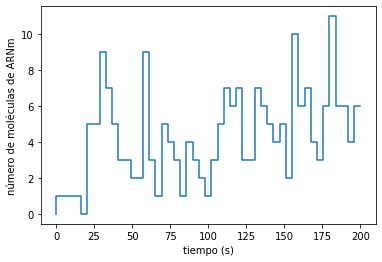

In [8]:
plt.xlabel('tiempo (s)')
plt.ylabel('número de moléculas de ARNm')
plt.step(una_celula[:,0],una_celula[:,1])

Consideremos ahora 10000 células. Definimos num_cel como el número de células que vamos a simular. 
Definimos la variable células como un array de numpy. 

In [9]:
num_cel = 10000 #número de células 
celulas = np.array([Estado_celula(x0,np.arange(0.,700.,2.)) for i in range(num_cel)])
celulas.shape

(10000, 350, 3)

Definimos el array de numpy células como una lista por comprensión. Se correrá la función Estado_celula, con las condiciones iniciales x0 y el vector de muestreo de tiempo tiempos, que tiene 350 elementos y va de 0 a 700, tantas veces como células haya en num_cel. La función shape nos dice entonces que hay 10000 células, es decir 10000 matrices, cada una con 350 filas y 3 columnas.

Una vez generadas nuestras 10000 células, procederemos a visualizar el comportamiento promedio. Usamos la función mean de numpy para promediar. Cuando axis=0, la función mean de numpy saca el promedio componente a componente de cada célula, es decir, promedio los tiempos de las células 1, 2, 3, ..., los ARNm de las células 1, 2, 3, ..., las proteínas de las células 1, 2, 3, ...., y genera una nueva matriz con esos promedios

In [10]:
celulas_prom = np.mean(celulas,axis=0) #axis = 0 saca el promedio componente a componente de cada célula.
celulas_prom

array([[0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [2.18710638e+00, 1.82550000e+00, 8.71093000e+01],
       [4.04364537e+00, 2.79110000e+00, 3.01935500e+02],
       ...,
       [6.94002106e+02, 4.95850000e+00, 1.12206232e+04],
       [6.96002118e+02, 4.98210000e+00, 1.12186445e+04],
       [6.98002144e+02, 4.99180000e+00, 1.12197882e+04]])

Graficamos entonces los tiempos (es decir, coge toda las filas y la columna 0, por eso el [:,0]) contra la cantidad de ARNm. Dado que las cantidades de ARNm son la segunda columna de nuestra matriz, por eso pedimos todas las filas y la columna 1 usando [:,1] (pues Python cuenta desde 0). Es decir, la línea 1 de la celda que se muestra a continuación ploteará la curva promedio.

Las líneas 3, 4, y 5 de la celda que se muestra a continuación graficarán las trayectorias de 5 células. El algoritmo, como se mostró antes, se corrió con 10000, pero se grafican solamente 5 para evitar la saturación de la figura. En la línea 5 es importante destacar que la primera 'componente' de células es la célula, es decir, célula 0, célula 1, célula 2, etc; la segunda componente son las filas, así que se piden todas; la tercera componente es la especie química de nuestro interés, de manera que en nuestro caso 0 es tiempo (que no es realmente una  especie química, pero así fue programado), 1 es ARNm y 2 es proteína.

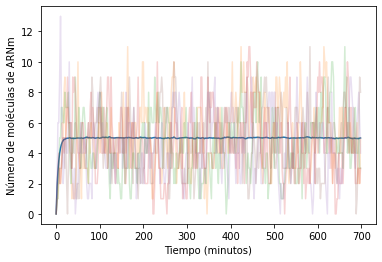

In [11]:
plt.xlabel('Tiempo (minutos)')
plt.ylabel('Número de moléculas de ARNm')
plt.plot(celulas_prom[:,0],celulas_prom[:,1])
for i in range(5):
    plt.plot(celulas[i,:,0],celulas[i,:,1],alpha=0.2) #el primero es la célula, el 2do es la fila 
                                                      #y el tercero, como es 0, es el tiempo. 
                                                      #Cuando es 2 es proteína. Depende de las especies 
                                                      #químicas que use.

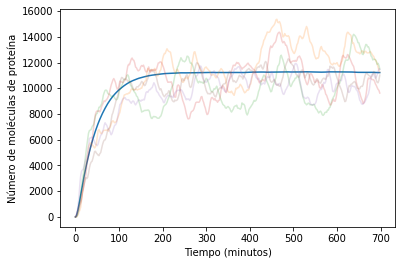

In [12]:
plt.xlabel('Tiempo (minutos)')
plt.ylabel('Número de moléculas de proteína')
plt.plot(celulas_prom[:,0],celulas_prom[:,2])
for i in range(5):
    plt.plot(celulas[i,:,0],celulas[i,:,2],alpha=0.2)

Para el caso de las proteínas esanálogo. Agarramos los tiempos (es decir, coge toda las filas y la columna 0. Dado que las cantidades de proteína son la tercera columna de nuestra matriz, pedimos todas las filas y la columna 2 usando [:,2] (pues Python cuenta desde 0). Es decir, al igual que antes, la línea 1 de la celda que se muestra a continuación ploteará la curva promedio.

Para obtener valores estadísticos como el promedio y la desviación estándar, tomamos los valores de todas las células evaluadas para ARNm y proteína en el estado estacionario (en este caso, los últimos 52 tiempos del vector del tiempo de muestreo). Para hacerlo, seguimos con que

Los últimos 52 valores de ARNm para todas las células vienen dados por

In [13]:
celulas[:,-52:,1]

array([[6., 7., 4., ..., 3., 2., 5.],
       [7., 5., 6., ..., 5., 3., 3.],
       [6., 7., 9., ..., 3., 2., 3.],
       ...,
       [2., 3., 3., ..., 2., 4., 6.],
       [2., 4., 3., ..., 3., 6., 3.],
       [4., 3., 2., ..., 3., 2., 4.]])

In [14]:
celulas[:,-52:,1].shape

(10000, 52)

Los últimos 52 valores de proteína para todas las células vienen dados por

In [15]:
celulas[:,-52:,2]

array([[11894., 11924., 11993., ..., 11659., 11399., 11252.],
       [ 9696.,  9893., 10042., ..., 11940., 11776., 11505.],
       [ 8997.,  9294.,  9689., ...,  9918.,  9838.,  9628.],
       ...,
       [ 7680.,  7594.,  7524., ...,  9346.,  9242.,  9355.],
       [ 9735.,  9554.,  9401., ..., 10420., 10383., 10432.],
       [ 8447.,  8463.,  8326., ...,  9278.,  9094.,  9048.]])

In [16]:
celulas[:,-52:,1].shape

(10000, 52)

El promedio y desviación estándar del ARNm

In [17]:
np.mean(celulas[:,-52:,1].ravel())

4.988357692307693

In [18]:
np.std(celulas[:,-52:,1].ravel())

2.226635750266286

El promedio y desviación estándar de las proteínas

In [19]:
np.mean(celulas[:,-52:,2].ravel())

11249.341855769231

In [20]:
np.std(celulas[:,-52:,2].ravel())

1584.948705351138

El ruido en el ARNm

In [26]:
np.std(celulas[:,-52:,1].ravel())/np.mean(celulas[:,-52:,1].ravel())

0.44636649727421795

In [27]:
(np.std(celulas[:,-52:,1].ravel())/np.mean(celulas[:,-52:,1].ravel()))**2

0.1992430498888544

El ruido en las proteínas

In [23]:
np.std(celulas[:,-52:,2].ravel())/np.mean(celulas[:,-52:,2].ravel())

0.1408925718208391

In [24]:
(np.std(celulas[:,-52:,2].ravel())/np.mean(celulas[:,-52:,2].ravel()))**2

0.019850716794290308

El ruido analítico para el ARNm vendrá dada por la expresión

$$
\eta_r^2 = \frac{1}{<m>} = \frac{\gamma_r}{k_r}
$$

In [25]:
γr/kr

0.2

Lo que coincide relativamente bien con el obtenido a partir de la simulación. 

El ruido analítico para las proteínas vendrá dado por la expresión

$$
\eta_p^2 = \frac{1}{<p>} + \frac{1}{<r>}\left(\frac{\gamma_p}{\gamma_p + \gamma_r}\right) = \frac{\gamma_p \gamma_r \left(k_p + \gamma_p + \gamma_r\right)}{k_p k_r \left(\gamma_p+\gamma_r\right)}
$$

In [28]:
1/((kp*kr)/(γr*γp)) + (γr/kr)*(γp/(γp+γr))

0.02008888888888889

Lo que, nuevamente, coincide relativamente bien con el ruido obtenido de la simulación.